# EfficientNet Model Evaluation


The trained baseline and dropout EfficientNet models are evaluated by doing inference on the test split of cross-datasets. To evaluate the application of Monte Carlo Dropout technique, each dropout model also does the inference with 50 Monte Carlo samples. The considered sample value is chosen based on the basic CNN Monte Carlo Sample experiments that resulted no significant performance aligning with the increasing Monte Carlo Sample that requires more computational cost. Each model's performance is interpreted by its ROC curve and AUC values.


In [1]:
from tensorflow.keras.applications import efficientnet
from tensorflow.keras.utils import load_img, img_to_array
from sklearn.metrics import roc_curve, auc, confusion_matrix
from matplotlib import pyplot as plt
from IPython.display import display
import tensorflow as tf
import pandas as pd
import numpy as np
import time
import os

%matplotlib inline

## Define Dataset Directory


In [2]:
CDF_DATASET_DIR = "/kaggle/input/deepfake-detection-datasets/Celeb-DF-v2/Test"
DF_DATASET_DIR = "/kaggle/input/deepfake-detection-datasets/DeeperForensics-1.0/Test"
DFDC_DATASET_DIR = "/kaggle/input/deepfake-detection-datasets/DFDC/Test"

## Define Trained Models Path


In [3]:
EFFICIENTNET_MODEL_DIR = "/kaggle/input/efficientnet-model-training"

In [4]:
baseline_efficientnet_cdf_model_path = os.path.join(
    EFFICIENTNET_MODEL_DIR, "baseline_efficientnet_cdf_model.keras"
)
baseline_efficientnet_df_model_path = os.path.join(
    EFFICIENTNET_MODEL_DIR, "baseline_efficientnet_df_model.keras"
)
baseline_efficientnet_dfdc_model_path = os.path.join(
    EFFICIENTNET_MODEL_DIR, "baseline_efficientnet_dfdc_model.keras"
)

In [5]:
dropout_efficientnet_cdf_model_path = os.path.join(
    EFFICIENTNET_MODEL_DIR, "dropout_efficientnet_cdf_model.keras"
)
dropout_efficientnet_df_model_path = os.path.join(
    EFFICIENTNET_MODEL_DIR, "dropout_efficientnet_df_model.keras"
)
dropout_efficientnet_dfdc_model_path = os.path.join(
    EFFICIENTNET_MODEL_DIR, "dropout_efficientnet_dfdc_model.keras"
)

## Load the Trained Models


In [6]:
baseline_efficientnet_cdf_model = tf.keras.models.load_model(
    baseline_efficientnet_cdf_model_path
)
baseline_efficientnet_df_model = tf.keras.models.load_model(
    baseline_efficientnet_df_model_path
)
baseline_efficientnet_dfdc_model = tf.keras.models.load_model(
    baseline_efficientnet_dfdc_model_path
)

In [7]:
dropout_efficientnet_cdf_model = tf.keras.models.load_model(
    dropout_efficientnet_cdf_model_path
)
dropout_efficientnet_df_model = tf.keras.models.load_model(
    dropout_efficientnet_df_model_path
)
dropout_efficientnet_dfdc_model = tf.keras.models.load_model(
    dropout_efficientnet_dfdc_model_path
)

## File Video Id Extraction Function


In [8]:
def extract_file_id(filepath):
    return filepath.split("-")[0]

## Image Preprocessing Function


In [9]:
def preprocess_image(filepath):
    image = load_img(filepath, target_size=(128, 128))
    image = img_to_array(image)
    image = efficientnet.preprocess_input(image)
    return image

## Get Dataset Metadata


In [10]:
def group_preprocessed_frames_by_file_id(dataset_dir, dataset_name):
    label_dirs = [
        os.path.join(dataset_dir, label) for label in ["Deepfake", "Original"]
    ]

    metadata = {"name": dataset_name, "videos": {}}

    for label_dir in label_dirs:
        label = 0 if label_dir.split("/")[-1] == "Deepfake" else 1
        for filename in os.listdir(label_dir):
            file_id = extract_file_id(filename)
            filepath = os.path.join(label_dir, filename)
            preprocessed_image = preprocess_image(filepath)

            if metadata["videos"].get(file_id) == None:
                metadata["videos"][file_id] = {"label": label, "data": []}

            metadata["videos"][file_id]["data"].append(preprocessed_image)

    return metadata

In [11]:
cdf_metadata = group_preprocessed_frames_by_file_id(
    CDF_DATASET_DIR, dataset_name="Celeb-DF-v2"
)
df_metadata = group_preprocessed_frames_by_file_id(
    DF_DATASET_DIR, dataset_name="DeeperForensics-1.0"
)
dfdc_metadata = group_preprocessed_frames_by_file_id(
    DFDC_DATASET_DIR, dataset_name="DFDC"
)

datasets = [cdf_metadata, df_metadata, dfdc_metadata]

## Evaluate Each Model in Cross Dataset


### Function to Get FPR, TPR, and AUC Metric Value of a Model's Prediction


In [12]:
def get_model_prediction_metrics_on_dataset(
    model,
    dataset_videos,
    mc_dropout=False,
    mc_sample_size=100,
):
    predictions = {"data_id": [], "y_true": [], "y_pred_score": []}

    for id in dataset_videos.keys():
        label = dataset_videos[id].get("label")
        predictions["y_true"].append(label)
        predictions["data_id"].append(id)

        images_data = np.array(dataset_videos[id].get("data"))
        images_data = tf.data.Dataset.from_tensor_slices(images_data)
        images_data = images_data.batch(len(images_data) // 2)

        frame_prediction_scores = []
        for batch_data in images_data:
            if mc_dropout:
                mc_prediction_scores = np.stack(
                    [model(batch_data, training=True) for _ in range(mc_sample_size)]
                )
                batch_prediction_scores = np.mean(mc_prediction_scores, axis=0)
            else:
                batch_prediction_scores = model(batch_data, training=False)
            frame_prediction_scores.extend(batch_prediction_scores)

        video_prediction_score = np.mean(frame_prediction_scores)
        predictions["y_pred_score"].append(video_prediction_score)

    fpr, tpr, _ = roc_curve(
        predictions["y_true"],
        predictions["y_pred_score"],
        drop_intermediate=False,
    )
    roc_auc = auc(fpr, tpr)

    y_pred = (np.array(predictions["y_pred_score"]) > 0.5).astype(int)
    cm = confusion_matrix(predictions["y_true"], y_pred).ravel()

    return fpr, tpr, roc_auc, cm, predictions

### Model Evaluation Function


In [13]:
def evaluate_model_on_cross_datasets(
    model,
    datasets,
    mc_dropout=False,
    mc_sample_size=100,
    model_name="Model",
):
    cm_data = {
        "Dataset": [],
        "TN": [],
        "FP": [],
        "FN": [],
        "TP": [],
    }

    prediction_data = {"dataset": [], "data_id": [], "y_true": [], "y_pred_score": []}

    plot_colors = ["dodgerblue", "red", "forestgreen"]

    plt.plot([0, 1], [0, 1], color="lightsteelblue", linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{model_name} ROC Curve")

    for i, dataset in enumerate(datasets):
        start_time = time.time()
        dataset_name = dataset.get("name")
        print(f"Evaluating on {dataset_name}...")
        fpr, tpr, roc_auc, cm, predictions = get_model_prediction_metrics_on_dataset(
            model,
            dataset.get("videos"),
            mc_dropout,
            mc_sample_size,
        )
        print(f"=> Finished in {round(time.time() - start_time, 3)} seconds\n")

        plt.plot(
            fpr,
            tpr,
            color=plot_colors[i],
            label=f"{dataset_name} (AUC = {round(roc_auc, 3)})",
        )

        prediction_data["dataset"].extend(
            [dataset_name for _ in range(len(predictions.get("data_id")))]
        )
        prediction_data["data_id"].extend(predictions.get("data_id"))
        prediction_data["y_true"].extend(predictions.get("y_true"))
        prediction_data["y_pred_score"].extend(predictions.get("y_pred_score"))

        tn, fp, fn, tp = cm
        cm_data["Dataset"].append(dataset_name)
        cm_data["TN"].append(tn)
        cm_data["FP"].append(fp)
        cm_data["FN"].append(fn)
        cm_data["TP"].append(tp)

    plt.legend(loc="lower right")
    plt.show()

    cm_df = pd.DataFrame(cm_data)
    display(cm_df)

    prediction_data_df = pd.DataFrame(prediction_data)
    prediction_data_filename = (
        model_name.lower().replace(" ", "-") + "-predictions" + ".csv"
    )
    prediction_data_df.to_csv(prediction_data_filename, index=False)

### Models Evaluation


In [14]:
x = baseline_efficientnet_cdf_model(
    np.array(datasets[0]["videos"]["id25_id24_0002"]["data"][:50])
)
del x

#### Trained on Celeb-DF-v2


##### Baseline Model


Evaluating on Celeb-DF-v2...
=> Finished in 65.175 seconds

Evaluating on DeeperForensics-1.0...
=> Finished in 65.051 seconds

Evaluating on DFDC...
=> Finished in 64.703 seconds



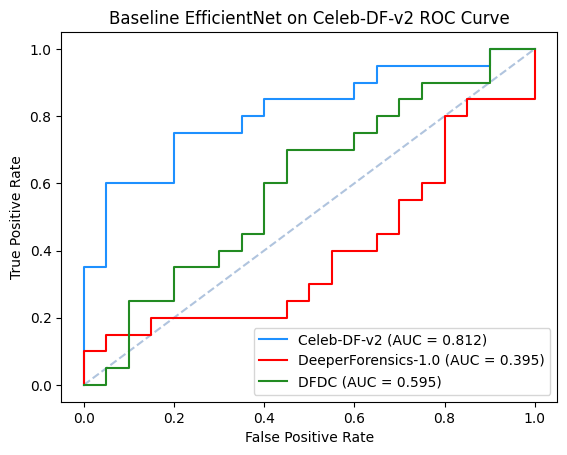

,Dataset,TN,FP,FN,TP
0,Celeb-DF-v2,4,16,1,19
1,DeeperForensics-1.0,0,20,0,20
2,DFDC,2,18,0,20


CPU times: user 3min 15s, sys: 1.38 s, total: 3min 16s
Wall time: 3min 15s


In [15]:
%%time
evaluate_model_on_cross_datasets(
    baseline_efficientnet_cdf_model,
    datasets,
    model_name="Baseline EfficientNet on Celeb-DF-v2"
)

##### Dropout Model


Evaluating on Celeb-DF-v2...
=> Finished in 65.029 seconds

Evaluating on DeeperForensics-1.0...
=> Finished in 64.68 seconds

Evaluating on DFDC...
=> Finished in 64.68 seconds



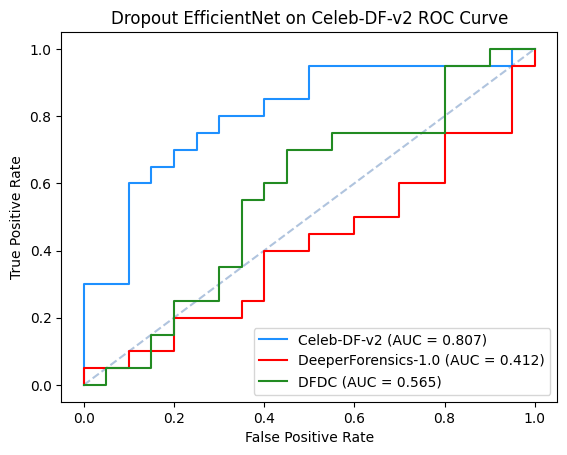

,Dataset,TN,FP,FN,TP
0,Celeb-DF-v2,4,16,1,19
1,DeeperForensics-1.0,0,20,0,20
2,DFDC,2,18,0,20


CPU times: user 3min 14s, sys: 1.11 s, total: 3min 16s
Wall time: 3min 14s


In [16]:
%%time
evaluate_model_on_cross_datasets(
    dropout_efficientnet_cdf_model,
    datasets,
    model_name="Dropout EfficientNet on Celeb-DF-v2"
)

##### Monte Carlo Dropout Model


Evaluating on Celeb-DF-v2...
=> Finished in 3631.954 seconds

Evaluating on DeeperForensics-1.0...
=> Finished in 3396.457 seconds

Evaluating on DFDC...
=> Finished in 3376.705 seconds



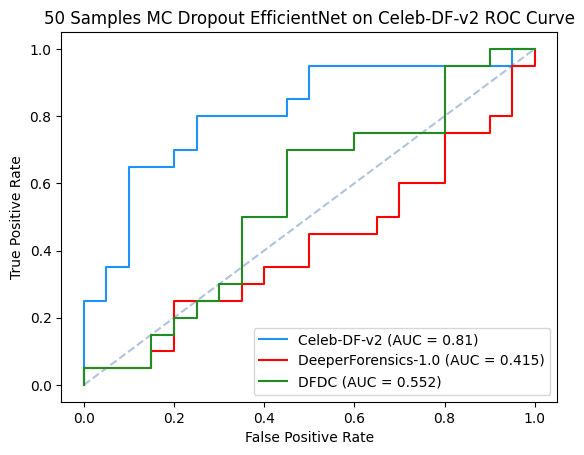

,Dataset,TN,FP,FN,TP
0,Celeb-DF-v2,4,16,1,19
1,DeeperForensics-1.0,0,20,0,20
2,DFDC,1,19,0,20


CPU times: user 2h 54min 19s, sys: 2min 9s, total: 2h 56min 28s
Wall time: 2h 53min 25s


In [17]:
%%time
evaluate_model_on_cross_datasets(
    dropout_efficientnet_cdf_model,
    datasets,
    mc_dropout=True,
    mc_sample_size=50,
    model_name="50 Samples MC Dropout EfficientNet on Celeb-DF-v2"

)

#### Trained on DeeperForensics-1.0


##### Baseline Model


Evaluating on Celeb-DF-v2...
=> Finished in 59.9 seconds

Evaluating on DeeperForensics-1.0...
=> Finished in 60.695 seconds

Evaluating on DFDC...
=> Finished in 60.378 seconds



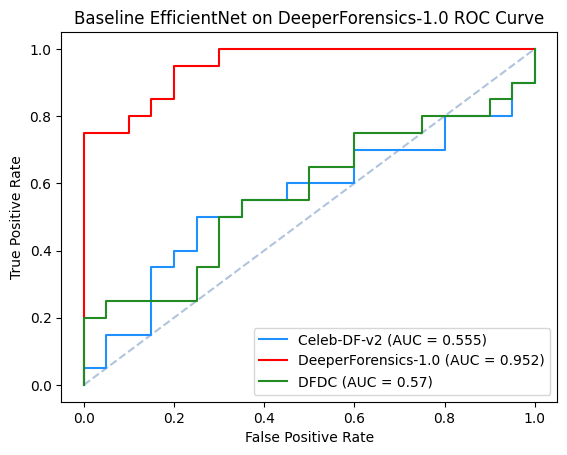

,Dataset,TN,FP,FN,TP
0,Celeb-DF-v2,3,17,4,16
1,DeeperForensics-1.0,16,4,3,17
2,DFDC,3,17,4,16


CPU times: user 3min 1s, sys: 1.11 s, total: 3min 2s
Wall time: 3min 1s


In [20]:
%%time
evaluate_model_on_cross_datasets(
    baseline_efficientnet_df_model,
    datasets,
    model_name="Baseline EfficientNet on DeeperForensics-1.0"
)

##### Dropout Model


Evaluating on Celeb-DF-v2...
=> Finished in 60.823 seconds

Evaluating on DeeperForensics-1.0...
=> Finished in 60.264 seconds

Evaluating on DFDC...
=> Finished in 60.688 seconds



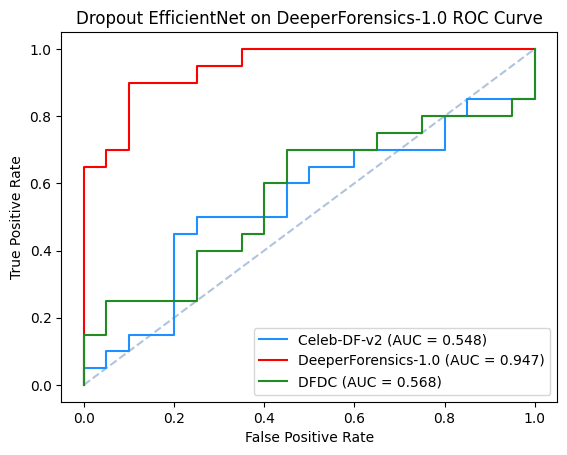

,Dataset,TN,FP,FN,TP
0,Celeb-DF-v2,5,15,6,14
1,DeeperForensics-1.0,18,2,4,16
2,DFDC,4,16,4,16


CPU times: user 3min, sys: 2.65 s, total: 3min 3s
Wall time: 3min 2s


In [21]:
%%time
evaluate_model_on_cross_datasets(
    dropout_efficientnet_df_model,
    datasets,
    model_name="Dropout EfficientNet on DeeperForensics-1.0"
)

##### Monte Carlo Dropout Model


Evaluating on Celeb-DF-v2...
=> Finished in 3769.316 seconds

Evaluating on DeeperForensics-1.0...
=> Finished in 3795.236 seconds

Evaluating on DFDC...
=> Finished in 3775.428 seconds



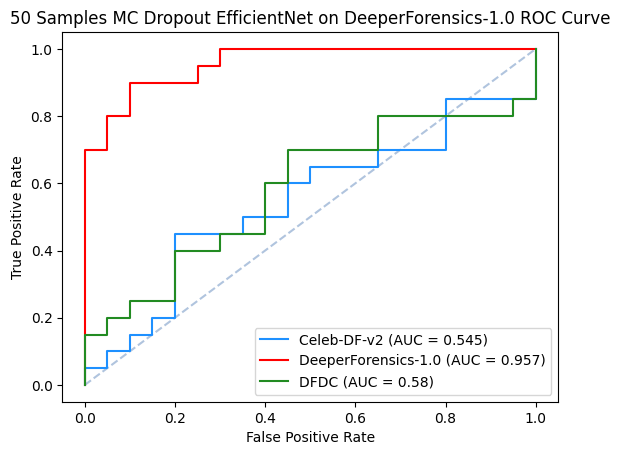

,Dataset,TN,FP,FN,TP
0,Celeb-DF-v2,4,16,6,14
1,DeeperForensics-1.0,18,2,4,16
2,DFDC,4,16,4,16


CPU times: user 3h 10min 20s, sys: 2min 23s, total: 3h 12min 44s
Wall time: 3h 9min


In [22]:
%%time
evaluate_model_on_cross_datasets(
    dropout_efficientnet_df_model,
    datasets,
    mc_dropout=True,
    mc_sample_size=50,
    model_name="50 Samples MC Dropout EfficientNet on DeeperForensics-1.0"
)

#### Trained on DFDC


##### Baseline Model


Evaluating on Celeb-DF-v2...
=> Finished in 67.861 seconds

Evaluating on DeeperForensics-1.0...
=> Finished in 68.557 seconds

Evaluating on DFDC...
=> Finished in 67.438 seconds



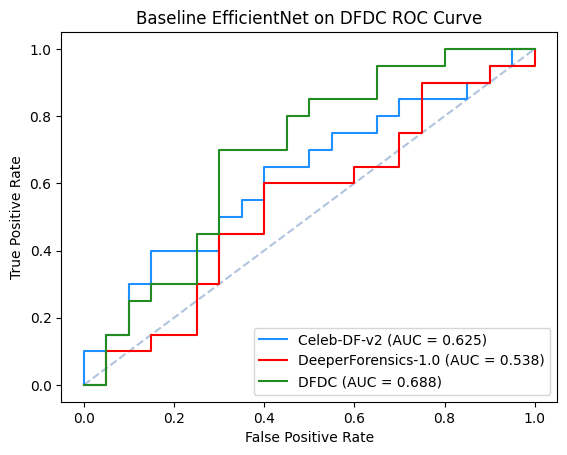

,Dataset,TN,FP,FN,TP
0,Celeb-DF-v2,2,18,2,18
1,DeeperForensics-1.0,2,18,1,19
2,DFDC,2,18,0,20


CPU times: user 3min 23s, sys: 2.13 s, total: 3min 25s
Wall time: 3min 24s


In [25]:
%%time
evaluate_model_on_cross_datasets(
    baseline_efficientnet_dfdc_model,
    datasets,
    model_name="Baseline EfficientNet on DFDC"
)

##### Dropout Model


Evaluating on Celeb-DF-v2...
=> Finished in 67.291 seconds

Evaluating on DeeperForensics-1.0...
=> Finished in 67.16 seconds

Evaluating on DFDC...
=> Finished in 67.228 seconds



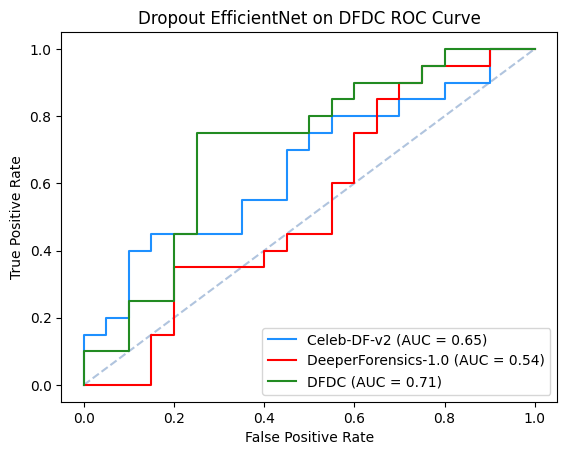

,Dataset,TN,FP,FN,TP
0,Celeb-DF-v2,5,15,3,17
1,DeeperForensics-1.0,3,17,1,19
2,DFDC,4,16,1,19


CPU times: user 3min 20s, sys: 2.79 s, total: 3min 23s
Wall time: 3min 21s


In [26]:
%%time
evaluate_model_on_cross_datasets(
    dropout_efficientnet_dfdc_model,
    datasets,
    model_name="Dropout EfficientNet on DFDC"
)

##### Monte Carlo Dropout Model


Evaluating on Celeb-DF-v2...
=> Finished in 3811.971 seconds

Evaluating on DeeperForensics-1.0...
=> Finished in 3780.543 seconds

Evaluating on DFDC...
=> Finished in 3731.351 seconds



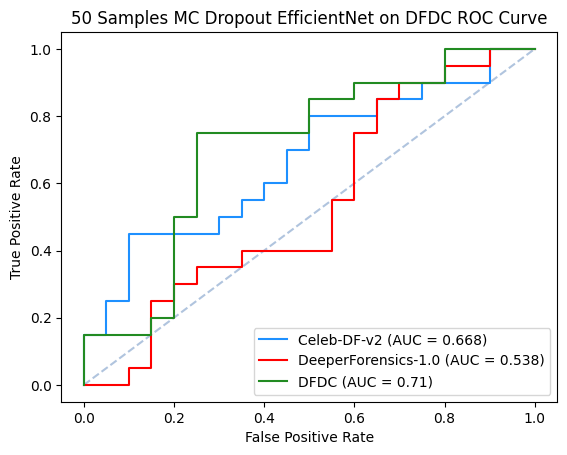

,Dataset,TN,FP,FN,TP
0,Celeb-DF-v2,3,17,2,18
1,DeeperForensics-1.0,4,16,1,19
2,DFDC,4,16,0,20


CPU times: user 3h 10min 2s, sys: 2min 27s, total: 3h 12min 29s
Wall time: 3h 8min 44s


In [27]:
%%time
evaluate_model_on_cross_datasets(
    dropout_efficientnet_dfdc_model,
    datasets,
    mc_dropout=True,
    mc_sample_size=50,
    model_name="50 Samples MC Dropout EfficientNet on DFDC"
)